In [1]:
from pauliopt.pauli.pauli_polynomial import PauliPolynomial
from pauliopt.pauli.pauli_gadget import PPhase
from pauliopt.pauli.utils import I, Z, X, Y
from pauliopt.utils import Angle, pi
from pauliopt.topologies import Topology

# Pauli Polynomials

## Pauli Gadgets

Pauli Gadgets are mathematical expressions defined as:

$$
P = \exp(-i \frac{\alpha}{2} \bigotimes_i P_i)
$$

Here, \(P_i\) represents one of the Pauli matrices:

- Pauli-X:
$$
X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}
$$
- Pauli-Y:
$$
Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}
$$
- Pauli-Z:
$$
Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}
$$
- Identity:
$$
I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
$$

A formal definition and further information on Pauli gadgets can be found [here](https://arxiv.org/abs/1906.01734).

Within `pauliopt`, Pauli gadgets are constructed in a similar way to Phase gadgets, following these steps:
- An angle is required, which can be an instance of `pauliopt.utils.Angle` or any object that satisfies the `pauliopt.utils.AngleProtocol` protocol.
- A list of legs is defined, where each leg corresponds to one of the Pauli matrices (X, Y, Z, I).
- The qubits spanned by the Pauli gadget are determined by the length of the list. If there are no qubits to be acted on, the Identity matrix is used.

Example:

In [2]:
pauli_gadget = PPhase(0.5) @ [I, Z, X, Y] # TODO Angle(pi)
pauli_gadget

(0.5) @ { I, Z, X, Y }

We can define a Pauli gadget on a quantum circuit by following these steps:

1. *Apply a set of Clifford gates:*
   - If the Pauli gadget is X, place the H-Gate on the corresponding qubit.
   - If the Pauli gadget is Y, apply the $\sqrt{X}$ or V-Gate on the corresponding qubit.
   - If the Pauli gadget is Z or the Identity, no additional gate is applied.
2. *Create a CNOT-Ladder:*
   - Implement a sequence of CNOT gates between the target qubit and the control qubits.
3. *Perform an Rz(alpha) rotation:*
   - Apply the Rz(alpha) gate on the target qubit.
4. *Undo the process:*
   - Reverse the CNOT-Ladder by applying the CNOT gates in the opposite order.
   - Reapply the Clifford gates in the reverse order to undo their effects.

Here's an example of a circuit showcasing these steps:

In [3]:
print(pauli_gadget.to_qiskit(Topology.line(4)))

                                                           
q_0: ──────────────────────────────────────────────────────
                     ┌───┐┌─────────┐┌───┐                 
q_1: ────────────────┤ X ├┤ Rz(0.5) ├┤ X ├─────────────────
        ┌───┐   ┌───┐└─┬─┘└─────────┘└─┬─┘┌───┐   ┌───┐    
q_2: ───┤ H ├───┤ X ├──■───────────────■──┤ X ├───┤ H ├────
     ┌──┴───┴──┐└─┬─┘                     └─┬─┘┌──┴───┴───┐
q_3: ┤ Rx(π/2) ├──■─────────────────────────■──┤ Rx(-π/2) ├
     └─────────┘                               └──────────┘


## Pauli Polynomial

To construct a Pauli polynomial, we can chain together multiple Pauli gadgets. Each Pauli gadget acts on a specific set of qubits and contributes to the overall transformation of the system (you can view this as n-dimensional rotations acting sequentially). 

Here's an example illustrating the construction of a Pauli polynomial:

In [4]:
pp = PauliPolynomial(5)

pp >>= PPhase(Angle(pi)) @ [I, I, X, Z, Y]
pp >>= PPhase(Angle(pi/2)) @ [X, X, I, I, Y]
pp >>= PPhase(Angle(pi/256)) @ [X, I, I, Z, Y]
pp >>= PPhase(Angle(pi/8)) @ [X, X, X, Z, Y]
pp >>= PPhase(Angle(pi/4)) @ [X, Z, I, I, Y]
pp >>= PPhase(Angle(pi/2)) @ [X, I, I, Y, Y]

# Representation in CLI applications
print(pp)

(π) @ { I, I, X, Z, Y }
(π/2) @ { X, X, I, I, Y }
(π/256) @ { X, I, I, Z, Y }
(π/8) @ { X, X, X, Z, Y }
(π/4) @ { X, Z, I, I, Y }
(π/2) @ { X, I, I, Y, Y }


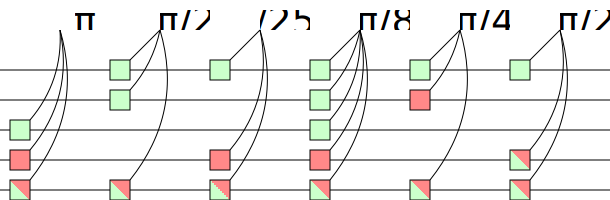

In [5]:
# SVG representation in e.g. Jupyter notebooks
pp

An example circuit of the Pauli Polynomial above, can be generated as follows:

In [6]:
print(pp.to_qiskit())

        ┌───┐                                                       ┌───┐┌───┐»
q_0: ───┤ H ├───────────────────────────────────────────────────────┤ X ├┤ X ├»
        ├───┤                                                       └─┬─┘└─┬─┘»
q_1: ───┤ H ├─────────────────────────────────────────────────────────┼────■──»
        ├───┤   ┌───┐┌───┐┌───────┐┌───┐┌───┐   ┌───┐       ┌───┐     │       »
q_2: ───┤ H ├───┤ X ├┤ X ├┤ Rz(π) ├┤ X ├┤ X ├───┤ H ├───────┤ H ├─────┼───────»
        └───┘   └─┬─┘└─┬─┘└───────┘└─┬─┘└─┬─┘   └───┘       └───┘     │       »
q_3: ─────────────┼────■─────────────■────┼───────────────────────────┼───────»
     ┌─────────┐  │                       │  ┌──────────┐┌─────────┐  │       »
q_4: ┤ Rx(π/2) ├──■───────────────────────■──┤ Rx(-π/2) ├┤ Rx(π/2) ├──■───────»
     └─────────┘                             └──────────┘└─────────┘          »
«     ┌─────────┐┌───┐┌───┐   ┌───┐       ┌───┐   ┌───┐┌───┐┌───────────┐┌───┐»
«q_0: ┤ Rz(π/2) ├┤ X ├┤ X ├───┤ H ├─────

It is also possible to route such a polynomial on a certain type of architecture

In [7]:
print(pp.to_qiskit(Topology.line(pp.num_qubits)))

        ┌───┐                                                                 »
q_0: ───┤ H ├─────────────────────────────────────────────────────────────────»
        ├───┤                                                                 »
q_1: ───┤ H ├─────────────────────────────────────────────────────────────────»
        ├───┤        ┌───┐┌───────┐┌───┐┌───┐                                 »
q_2: ───┤ H ├────────┤ X ├┤ Rz(π) ├┤ X ├┤ H ├─────────────────────────────────»
        └───┘   ┌───┐└─┬─┘└───────┘└─┬─┘├───┤                            ┌───┐»
q_3: ───────────┤ X ├──■─────────────■──┤ X ├─────────────────────────■──┤ X ├»
     ┌─────────┐└─┬─┘                   └─┬─┘┌──────────┐┌─────────┐┌─┴─┐└─┬─┘»
q_4: ┤ Rx(π/2) ├──■───────────────────────■──┤ Rx(-π/2) ├┤ Rx(π/2) ├┤ X ├──■──»
     └─────────┘                             └──────────┘└─────────┘└───┘     »
«                    ┌───┐┌─────────┐┌───┐┌───┐┌───┐                           »
«q_0: ───────────────┤ X ├┤ Rz(π/2) ├┤ 